In [1]:
# Import packages
import scipy as sp
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import ot
import time
from ot.bregman import sinkhorn
from ot.utils import dist
from ot.optim import cg
import gromovWassersteinAveraging as gwa

import os 
from os.path import dirname, join as pjoin
import scipy.io as sio

# Importing the Shape Data

In [2]:
data_dir = os.getcwd() # Get the current working directory name.
mat_fname = pjoin(data_dir, 'planarShapes.mat') 
# Add the file name to the current working directory.

mat_contents = sio.loadmat(mat_fname) # Read the file

planarShapes = mat_contents['planarShapes']
planarShapes.shape

(2, 100, 1300)

# Classification

Let's try some simple classification task. We will classify shapes by class using the Riemannian algorithm. This is an easy classification task if we are given the 'labeled' points -- i.e. points in the matrix are given in order along the curves. To make things more interesting, I'll permute the order of the points in each curve.

We first import a few classes of shapes (we will want to increase the number for a real experiment).

In [3]:
indices = [0,20,40,60,80,100,120,140,160,180,200,220,240,260,280,300,320,340,360,380]

num_classes = len(indices)

num_shapes = 20*num_classes

labels = []

for j in range(num_classes):
    labels = labels + 20*[j]

shapes = planarShapes[:,:,indices[0]:indices[0]+20]

for j in range(1,len(indices)):
    shapes = np.concatenate((shapes,planarShapes[:,:,indices[j]:indices[j]+20]),axis=2)
    
print('num_classes = ',num_classes)
print('num_shapes = ', num_shapes)

num_classes =  20
num_shapes =  400


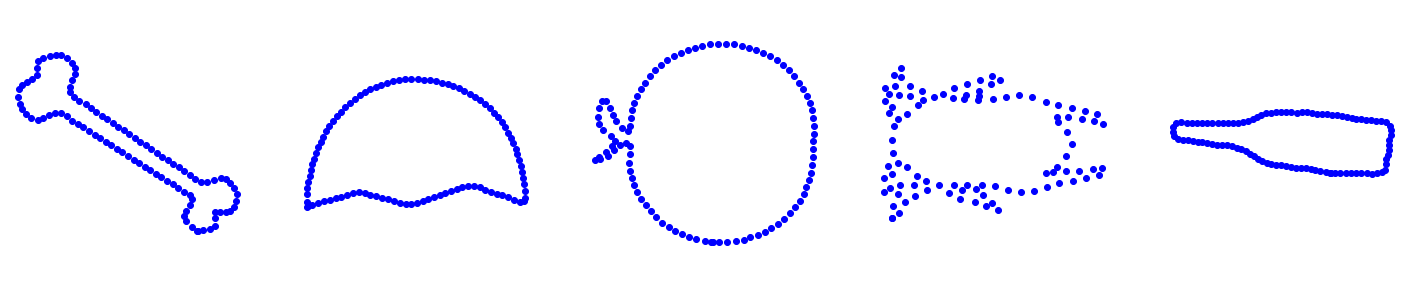

In [4]:
fig = plt.figure(figsize = (25,5))

for j in range(5):
    fig.add_subplot(1,5,j+1)
    plt.plot(shapes[0, :,50*j], shapes[1, :,50*j], 'ob');
    plt.axis('equal');
    plt.axis('off')

Convert the shapes to cost matrices. We include a permutation step to mix up the points along the curve.

In [5]:
CList = []
pList = []
p = ot.unif(100)

for j in range(num_shapes):
    shape = shapes[:,:,j]
    C = sp.spatial.distance.cdist(np.transpose(shape), np.transpose(shape))
    perm = np.random.permutation(np.eye(100))
    C = np.matmul(np.matmul(perm,C),perm.T)
    CList.append(C)
    pList.append(p)

## Preparing the Training Data

There are a few preliminary steps to prepare the training data for the Riemannian algorithms.

### Train/Test Split

We split the cost matrices into a training set and a testing set.

Import some machine learning functions.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

Reshape `CList` into a big matrix.

In [7]:
CListMatrix = np.zeros([num_shapes,100*100])

for j in range(num_shapes):
    C = CList[j].reshape(1,100*100)
    CListMatrix[j,:] = C

Split the feature vectors and labels into training and testing sets.

In [8]:
X = CListMatrix
y = labels

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [21]:
train_size = X_train.shape[0]
test_size = X_test.shape[0]

print(train_size,test_size)

300 100


Now we reshape the training and testing vectors into lists of cost matrices once again.

In [22]:
CList_train = [X_train[j,:].reshape(100,100) for j in range(train_size)]
CList_test = [X_test[j,:].reshape(100,100) for j in range(test_size)]

### Compute the Average

To train any classifier in the Riemannian setting, we first find the average cost matrix from the testing set.

In [23]:
CnBase, pnBase, Frechet_Loss = gwa.network_karcher_mean_armijo_sched(CList_train[0],pList[0],CList_train,pList,20,50)

Iter Frechet_Loss
0 49847302.89841316
current size  (100, 100)
1 19090568.235538132  full steps
current size  (100, 100)
2 17506092.50642438  full steps
current size  (100, 100)
3 17317609.272966314  full steps
current size  (100, 100)
4 17235061.913078688  full steps
current size  (100, 100)
5 17173868.357179705  full steps
current size  (100, 100)
6 17285907.600324027  full steps
current size  (100, 100)
7 17441520.49477264  full steps
current size  (100, 100)
8 17088374.112948988  full steps
current size  (100, 100)
9 17045190.883062575  full steps
current size  (100, 100)
10 17088177.06417659  full steps
current size  (100, 100)
11 17050218.043147866  full steps
current size  (100, 100)
12 17013867.892193682  full steps
current size  (100, 100)
13 17010348.579679623  full steps
current size  (100, 100)
14 16982835.599861294  full steps
current size  (100, 100)
15 16977669.94909279  full steps
current size  (100, 100)
16 16916353.13302417  full steps
current size  (100, 100)
17 1702

### Log Matrices to the Average

Next we log all matrices (training and testing) back to the average and reshape. The result is our training and testing set for the Riemannian-based classification algorithms.

In [24]:
CAvg = CnBase

vectors_train = np.zeros((train_size,100*100))

for j in range(train_size):
    C0, C1, p, q, vec, opt_coup = gwa.log_map(CAvg,CList_train[j],pList[0],pList[j])
    vec = vec.reshape(1,100*100)
    vectors_train[j,:] = vec
    
vectors_test = np.zeros((test_size,100*100))

for j in range(test_size):
    C0, C1, p, q, vec, opt_coup = gwa.log_map(CAvg,CList_test[j],pList[0],pList[j])
    vec = vec.reshape(1,100*100)
    vectors_test[j,:] = vec

### Create Naive Baseline

We should also test everything without doing any alignment or anything interesting. We could just treat each cost matrix as a vector and do classification in the space of unaligned cost matrices.

In [25]:
vectorsBaseline_train = np.zeros((train_size,100*100))

for j in range(train_size):
    vectorsBaseline_train[j,:] = CList_train[j].reshape(1,100*100)
    
vectorsBaseline_test = np.zeros((test_size,100*100))

for j in range(test_size):
    vectorsBaseline_test[j,:] = CList_test[j].reshape(1,100*100)

### Create Less Naive Baseline

We could also do *some* alignment by picking one of the shapes in the training set, aligning everything to it and pulling back to tangent vectors.

In [26]:
CAvgLNB = CList_train[0]

vectorsLNB_train = np.zeros((train_size,100*100))

for j in range(train_size):
    C0, C1, p, q, vec, opt_coup = gwa.log_map(CAvgLNB,CList_train[j],pList[0],pList[j])
    vec = vec.reshape(1,100*100)
    vectorsLNB_train[j,:] = vec
    
vectorsLNB_test = np.zeros((test_size,100*100))

for j in range(test_size):
    C0, C1, p, q, vec, opt_coup = gwa.log_map(CAvgLNB,CList_test[j],pList[0],pList[j])
    vec = vec.reshape(1,100*100)
    vectorsLNB_test[j,:] = vec

## Run Classification

Now that we have suitable training and testing vectors for both the Riemannian algorithms and the naive algorithm, we can run whatever classification algorithms we like.

### Support Vector Machine

Classify the shapes using SVM classification.

In [27]:
modelSVM = SVC(kernel="linear",C=1)

#### Riemannian Algorithm

In [28]:
modelSVM.fit(vectors_train, y_train)
print(modelSVM.score(vectors_train,y_train))
print(modelSVM.score(vectors_test,y_test))

1.0
0.94


#### Naive Baseline

In [29]:
modelSVM.fit(vectorsBaseline_train, y_train)
print(modelSVM.score(vectorsBaseline_train, y_train))
print(modelSVM.score(vectorsBaseline_test,y_test))

1.0
0.19


#### Less Naive Baseline


In [30]:
modelSVM.fit(vectorsLNB_train, y_train)

print(modelSVM.score(vectorsLNB_train,y_train))
print(modelSVM.score(vectorsLNB_test,y_test))

1.0
0.84
